# Who's the biggest tax evader?

#### Imports:

In [109]:
import plotly.plotly as py
import pandas as pd
import pycountry
import plotly.graph_objs as go
import numpy as np
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

## 1. Data cleaning and preprocessing

In [2]:
# Load country codes
df_country_codes = pd.read_csv('data/countries_codes.csv', low_memory=False).set_index('COUNTRY')

In [3]:
# Load datasets
## Load panama papers datasets
pp_edges = pd.read_csv('data/panama_papers/panama_papers.edges.csv', low_memory=False)
pp_nodes_address = pd.read_csv('data/panama_papers/panama_papers.nodes.address.csv', low_memory=False)
pp_nodes_entity = pd.read_csv('data/panama_papers/panama_papers.nodes.entity.csv', low_memory=False)
pp_nodes_intermediary = pd.read_csv('data/panama_papers/panama_papers.nodes.intermediary.csv', low_memory=False)
pp_nodes_officer = pd.read_csv('data/panama_papers/panama_papers.nodes.officer.csv', low_memory=False)
## Load UN datasets
un_hdi_components_2014 = pd.read_csv('data/un/hdi_components.csv', low_memory=False)
un_gdp_per_capita = pd.read_csv('data/un/gdp_per_capita.csv', low_memory=False)
un_gdp_per_capita_ppp = pd.read_csv('data/un/gdp_per_capita_PPP.csv', low_memory=False)
## Load world bank datasets
wb_gini = pd.read_csv('data/world_bank/gini_index.csv', low_memory=False)
wb_income_share_20_per = pd.read_csv('data/world_bank/income_share_20_per.csv', low_memory=False)
wb_population_total = pd.read_csv('data/world_bank/population_total.csv', low_memory=False)

In [4]:
# We only consider statistics that date from 2000 onwards
years_to_drop = list(map(str, np.arange(1960, 2000)))
wb_gini = wb_gini.drop(columns=years_to_drop)
wb_income_share_20_per = wb_income_share_20_per.drop(columns=years_to_drop)

In [5]:
# We select the rightmost value (most recent) for each row
gini_values = wb_gini.stack().groupby(level=0).last().reindex(wb_gini.index)

# Only select valid values and label other values as NaN
wb_gini['Gini'] = pd.to_numeric(gini_values, errors='coerce')

# Only select relevant columns
wb_gini = wb_gini[['Country Name', 'Country Code', 'Gini']]

In [6]:
# We select the rightmost value (most recent) for each row
income_share_20_per_values = wb_income_share_20_per.stack().groupby(level=0).last().reindex(wb_income_share_20_per.index)

# Only select valid values and label other values as NaN
wb_income_share_20_per['Income Share'] = pd.to_numeric(income_share_20_per_values, errors='coerce')

# Only select relevant columns
wb_income_share_20_per = wb_income_share_20_per[['Country Name', 'Country Code', 'Income Share']]

In [7]:
# Join UN datasets with country codes DataFrame
un_hdi_components_2014 = un_hdi_components_2014.join(df_country_codes, on='Country')
un_gdp_per_capita = un_gdp_per_capita.join(df_country_codes, on='Country')
un_gdp_per_capita_ppp = un_gdp_per_capita_ppp.join(df_country_codes, on='Country')

In [8]:
# List of UN DataFrames
un_dfs = [un_hdi_components_2014, un_gdp_per_capita, un_gdp_per_capita_ppp]

# Define dictionary containing pairs (country name: ISO country code)
countries = dict()

for country in pycountry.countries:
    countries[country.name] = country.alpha_3  

for df in un_dfs:
    nan_values = df['CODE'].isna()
    input_countries = list(df[nan_values]['Country'].values)
        
    codes = []
    for country in input_countries:
        if country in countries:
            codes.append(countries.get(country))
        else:        
            accepted = []
            str_country = str(country)
            # check if string contains either common or official country name
            for p_country in pycountry.countries:
                if p_country.name in str_country or (hasattr(p_country, 'common_name') and p_country.common_name in str_country):
                    accepted.append(p_country.alpha_3)
            if len(accepted) == 1:
                codes.append(accepted[0])
            else:
                codes.append(None)

    df.loc[nan_values, 'CODE'] = codes
    # Remove rows that were not found
    df = df[df['CODE'].notnull()]

In [9]:
pp_references_country = pp_nodes_address.groupby(['country_codes', 'countries']).size().reset_index(name='counts')

In [10]:
wb_population_2014 = wb_population_total[['Country Code', '2014']]
occurrence_pop = pp_references_country.merge(wb_population_2014, left_on='country_codes', right_on='Country Code')
occurrence_pop['counts_1000'] = 1000 * occurrence_pop['counts'] / occurrence_pop['2014']

## 2. Data analysis and observations

### 2.1 Panama Papers and population

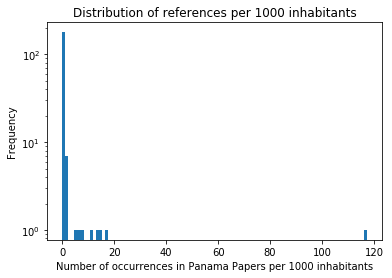

In [11]:
occurrence_pop['counts_1000'].plot.hist(title='Distribution of references per 1000 inhabitants', bins=100, logy=True)
plt.xlabel('Number of occurrences in Panama Papers per 1000 inhabitants')
plt.show()

In [12]:
pp_intermediary_country = pp_nodes_intermediary.groupby(['country_codes', 'countries']).size().reset_index(name='counts')
pp_intermediary_country = pp_intermediary_country.sort_values('counts', ascending=False)

We display the distribution using a map:

In [13]:
data = [ dict(
        type = 'choropleth',
        locations = pp_intermediary_country['country_codes'],
        z = pp_intermediary_country['counts'],
        text = pp_intermediary_country['countries'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Number of references'),
      ) ]

"""
layout = {
  "geo": {
    "coastlinewidth": 2, 
    "countrycolor": "rgb(204, 204, 204)", 
    "lakecolor": "rgb(255, 255, 255)", 
    "landcolor": "rgb(204, 204, 204)", 
    "lataxis": {
      "dtick": 10, 
      "range": [20, 60], 
      "showgrid": True
    }, 
    "lonaxis": {
      "dtick": 20, 
      "range": [-100, 20], 
      "showgrid": True
    }, 
    "projection": {"type": "equirectangular"}, 
    "resolution": 50, 
    "showlakes": True, 
    "showland": False
  }, 
  "showlegend": False, 
  "title": "Seoul to Hong Kong Great Circle"
}

"""
layout = dict(
    title = 'References in Panama Papers',
    geo = dict(
        showcountries = True,
        countrycolor = "rgb(217, 217, 217)",
        showframe = False,
        resolution=50,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        ),
        bgcolor = 'rgba(255, 255, 255, 0.0)',
    )
)


fig = dict( data=data, layout=layout )

iplot( fig, validate=False)

In [14]:
min_count = pp_intermediary_country['counts'].min()
max_count = pp_intermediary_country['counts'].max()

In [15]:
def firstOrDefault(values, default):
    if values is None or len(values) == 0:
        return default
    return values[0]

## 3. Milestone 3

We can see from the tables that most of the countries involved in the Panama Papers affair are small islands, which unfortunately are not displayed by the `Plotly` library. For the next milestone, we will fix that issue either by finding a solution that still works with `Plotly` or by using a different library, such as `folium`.

So far, we have made insightful observations that match the reports found in the media, particularly about which countries were most involved in this affair.

For the next milestone, we will further investigate the links between the countries, and try to understand the correlation of socio-economic factors with the locations of entities, officers and intermediaries involved in Panama Papers. More specifically, we intend to:
- Find which socio-economic factors are correlated with the results we found so far, and how they are correlated
- Display the links between the countries using a graph similar to the one found [here](https://plot.ly/python/lines-on-maps/)
- Fix issues with certain countries (particularly small islands) not being displayed in the graph
-

In [16]:
pp_edges_parsed = pp_edges[['START_ID', 'TYPE', 'END_ID']]

In [17]:
pp_nodes_intermediary_parsed = pp_nodes_intermediary[['node_id', 'country_codes', 'countries']]
pp_nodes_entity_parsed = pp_nodes_entity[['node_id', 'country_codes', 'countries']]
pp_nodes_officer_parsed = pp_nodes_officer[['node_id', 'country_codes', 'countries']]

In [18]:
pp_nodes = pp_nodes_entity_parsed.append(pp_nodes_intermediary_parsed).append(pp_nodes_officer_parsed)
pp_nodes = pp_nodes.dropna()

In [19]:
pp_edges_countries = pp_nodes.merge(pp_edges_parsed, left_on='node_id', right_on='START_ID')
pp_edges_countries = pp_edges_countries.rename(columns={'node_id': 'id_origin', 'country_codes': 'cc_origin', 
                                                        'countries': 'c_origin'})
pp_edges_countries = pp_edges_countries.merge(pp_nodes, left_on='END_ID', right_on='node_id')
pp_edges_countries = pp_edges_countries.rename(columns={'node_id': 'id_dest', 'country_codes': 'cc_dest', 
                                                        'countries': 'c_dest'})
pp_edges_countries = pp_edges_countries.drop(columns=['id_origin', 'id_dest'])

## Scatter plot 

In [54]:

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [21]:
pp_references_country.head()

,country_codes,countries,counts
0,ABW,Aruba,18
1,AGO,Angola,38
2,AIA,Anguilla,105
3,ALB,Albania,23
4,AND,Andorra,35


In [79]:
pp_references_country = pp_nodes_address.groupby(['country_codes', 'countries']).size().reset_index(name='counts')

In [78]:
pp_references_country.sort_values('counts', ascending=False).head()

,country_codes,countries,counts
33,CHN,China,20267
75,HKG,Hong Kong,9147
61,GBR,United Kingdom,3996
193,VGB,British Virgin Islands,3467
155,RUS,Russia,3346


In [83]:
pp_references_officier = pp_nodes_officer.groupby(['country_codes', 'countries']).size().reset_index(name='counts')
pp_references_officier.sort_values('counts', ascending=False).head()

,country_codes,countries,counts
33,CHN,China,24635
75,HKG,Hong Kong,13362
192,VGB,British Virgin Islands,11231
90,JEY,Jersey,6892
142,PAN,Panama,5069


In [84]:
pp_references_entity = pp_nodes_entity.groupby(['country_codes', 'countries']).size().reset_index(name='counts')
pp_references_entity.sort_values('counts', ascending=False).head()

,country_codes,countries,counts
59,HKG,Hong Kong,37911
27,CHE,Switzerland,37911
114,PAN,Panama,15811
73,JEY,Jersey,14331
89,LUX,Luxembourg,10840


In [85]:
pp_references_intermediary = pp_nodes_intermediary.groupby(['country_codes', 'countries']).size().reset_index(name='counts')
pp_references_intermediary.sort_values('counts', ascending=False).head()

,country_codes,countries,counts
91,HKG,Hong Kong,2202
75,GBR,United Kingdom,1367
28,CHE,Switzerland,1218
217,USA,United States,603
161,PAN,Panama,552


In [100]:
gdp_2015 = un_gdp_per_capita[un_gdp_per_capita['Year'] == 2015][['CODE', 'Value']]

In [102]:
gdp_2015.head()

,CODE,Value
1,AFG,610.854517
48,ALB,3877.487975
95,DZA,4160.218690
142,AND,36039.907860
189,AGO,4133.025039


In [119]:
nodes_types = [pp_references_country, pp_references_entity, pp_references_intermediary, pp_references_officier]

In [117]:
pp_references_officier.head()

,country_codes,countries,counts
0,ABW,Aruba,29
1,AGO,Angola,57
2,AIA,Anguilla,237
3,ALB,Albania,25
4,AND,Andorra,50


In [126]:
gdp_data = [x[x['counts'] > 300].merge(gdp_2015, left_on='country_codes', right_on='CODE') for x in nodes_types]

In [127]:
for d in gdp_data:
    # Create a trace
    trace = go.Scatter(
        x = d['counts'],
        y = d['Value'],
        mode = 'markers',
        text = d['countries']
    )

    data = [trace]

    # Plot and embed in ipython notebook!
    iplot(data)

In [138]:
gini_nan = wb_gini.dropna()

In [146]:
gini_data = [x[x['counts'] > 200].merge(gini_nan, left_on='country_codes', right_on='Country Code') for x in nodes_types]

In [147]:
gini_data[0].head(2)

,country_codes,countries,counts,Country Name,Country Code,Gini
0,ARG,Argentina,750,Argentina,ARG,42.4
1,AUS,Australia,755,Australia,AUS,34.7


In [148]:
for d in gini_data:
    # Create a trace
    trace = go.Scatter(
        y = d['Gini'],
        x= d['counts'],
        mode = 'markers',
        text = d['countries']
    )

    data = [trace]

    # Plot and embed in ipython notebook!
    iplot(data)

In [150]:
len(wb_income_share_20_per)

264

In [160]:
wb_income_share_nan = wb_income_share_20_per.dropna()

In [161]:
wb_income_share_nan.head(2)

,Country Name,Country Code,Income Share
2,Angola,AGO,48.5
3,Albania,ALB,37.8


In [162]:
income_share_data = [x[x['counts'] > 0].merge(wb_income_share_nan, left_on='country_codes', right_on='Country Code') for x in nodes_types]


In [174]:
income_share_data[3].corr()

,counts,Income Share
counts,1.000000,-0.388245
Income Share,-0.388245,1.000000


In [164]:
for d in income_share_data:
    # Create a trace
    trace = go.Scatter(
        y = d['Income Share'],
        x= d['counts'],
        mode = 'markers',
        text = d['countries']
    )

    data = [trace]

    # Plot and embed in ipython notebook!
    iplot(data)